In [1]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7]]
                data.append(columns)

    return data

In [3]:
tcp_ccas = ([ 'TcpNewReno', 'TcpCubic', 'TcpVegas', 'TcpBbrV2', 'TcpModNewReno'])
BDP = 173
buffer_sizes = ([0, 10, 43, 87, 130, 1*BDP, 2*BDP, 3*BDP, 4*BDP, 5*BDP, 6*BDP, 7*BDP, 8*BDP, 9*BDP, 10*BDP]) 
print(tcp_ccas)
print(buffer_sizes)

['TcpNewReno', 'TcpCubic', 'TcpVegas', 'TcpBbrV2', 'TcpModNewReno']
[0, 10, 43, 87, 130, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730]


In [4]:
data_in = {}
resulting_data = {}
for algorithm in tcp_ccas:
    resulting_data[algorithm] ={'buffer': list(), 'avETH': list(),'avTH': list(), 'PLR': list(), 'insTH': list()}
    
for b in buffer_sizes:
    b_bdp = b/173
    data_in[b_bdp] = {}
    for algorithm in tcp_ccas:
        data_in[b_bdp][algorithm]={'time': list(), 'avETH': list(), 'avTH': list(), 'PLR': list(), 'insTH': list()}
        files = []
        files.append("sim4_tikhonov/5-flows/10Mbps-100ms/" + str(b) 
              + "p-btlqueue/" + algorithm + "-5-flows-10Mbps-100ms-" + str(b)
              + "p-btlqueue-PerfData.dat")
        
        for file_name in files:
            raw_data = import_csv(file_name);
            for row in raw_data:
                data_in[b_bdp][algorithm]['time'].append({row[0]})
                data_in[b_bdp][algorithm]['avETH'].append({row[1]})
                data_in[b_bdp][algorithm]['avTH'].append({row[2]})
                data_in[b_bdp][algorithm]['PLR'].append({row[3]})
                data_in[b_bdp][algorithm]['insTH'].append({row[7]})
                #print(row[1], row[2], row[3], row[4])

            resulting_data[algorithm]['buffer'].append(b/173)
            resulting_data[algorithm]['avETH'].append(\
                        pd.DataFrame(list(data_in[b_bdp][algorithm]['avETH'][-1])).astype(float))
            resulting_data[algorithm]['avTH'].append(\
                        pd.DataFrame(list(data_in[b_bdp][algorithm]['avTH'][-1])).astype(float))
            resulting_data[algorithm]['PLR'].append(\
                        pd.DataFrame(list(data_in[b_bdp][algorithm]['PLR'][-1])).astype(float))
            resulting_data[algorithm]['insTH'].append(\
                        pd.DataFrame(list(data_in[b_bdp][algorithm]['insTH'])).astype(float).mean())

In [5]:
print(resulting_data['TcpNewReno']['avETH'][0])
print(resulting_data['TcpNewReno']['avTH'][0])
print(resulting_data['TcpNewReno']['PLR'][0])

       0
0  8.706
       0
0  8.874
        0
0  0.0189


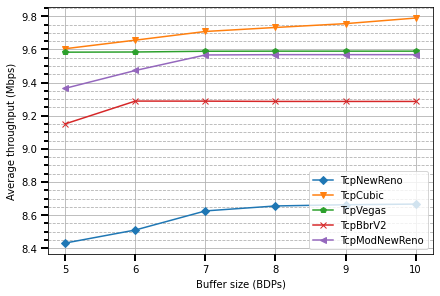

In [13]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
        resulting_data[tcp_ccas[0]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[0]]['insTH']).
         rolling(window=10, win_type=None).mean(), 'D-',
        resulting_data[tcp_ccas[1]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[1]]['insTH']).
         rolling(window=10, win_type=None).mean(), 'v-',
        resulting_data[tcp_ccas[2]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[2]]['insTH']).
         rolling(window=10, win_type=None).mean(), 'p-',
        resulting_data[tcp_ccas[3]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[3]]['insTH']).
         rolling(window=10, win_type=None).mean(), 'x-',
        resulting_data[tcp_ccas[4]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[4]]['insTH']).
         rolling(window=10, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'Average throughput (Mbps)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(9,10)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]], loc='lower right')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('insTH_vs_buffer_macro.png', transparent=True)

KeyError: (slice(None, None, None), None)

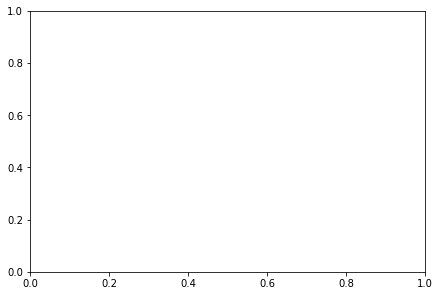

In [20]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
        resulting_data[tcp_ccas[0]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[0]]['avTH']), 'D-',
        resulting_data[tcp_ccas[1]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[1]]['avTH']).
         rolling(window=1, win_type=None).mean(), 'v-',
        resulting_data[tcp_ccas[2]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[2]]['avTH']).
         rolling(window=1, win_type=None).mean(), 'p-',
        resulting_data[tcp_ccas[3]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[3]]['avTH']).
         rolling(window=1, win_type=None).mean(), 'x-',
        resulting_data[tcp_ccas[4]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[4]]['avTH']).
         rolling(window=1, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'Average throughput (Mbps)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(7,10)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]], loc='lower right')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('avTH_vs_buffer.png', transparent=True)

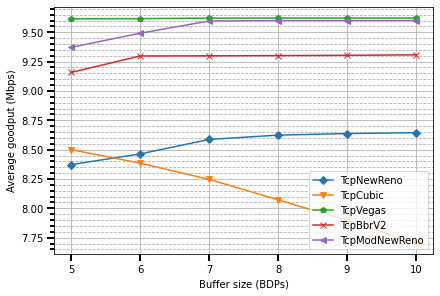

In [15]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
        resulting_data[tcp_ccas[0]]['buffer'], 
                pd.DataFrame(resulting_data[tcp_ccas[0]]['avETH']).
         rolling(window=10, win_type=None).mean(), 'D-',
        resulting_data[tcp_ccas[1]]['buffer'], 
                pd.DataFrame(resulting_data[tcp_ccas[1]]['avETH']).
         rolling(window=10, win_type=None).mean(), 'v-',
        resulting_data[tcp_ccas[2]]['buffer'], 
                pd.DataFrame(resulting_data[tcp_ccas[2]]['avETH']).
         rolling(window=10, win_type=None).mean(), 'p-',
        resulting_data[tcp_ccas[3]]['buffer'], 
                pd.DataFrame(resulting_data[tcp_ccas[3]]['avETH']).
         rolling(window=10, win_type=None).mean(), 'x-',
        resulting_data[tcp_ccas[4]]['buffer'], 
                pd.DataFrame(resulting_data[tcp_ccas[4]]['avETH']).
         rolling(window=10, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'Average goodput (Mbps)')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(7,10)
#plt.xlim(0.0001,10)
plt.grid(True)
plt.legend([tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]], loc='lower right')
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('goodput_vs_buffer.png', transparent=True)

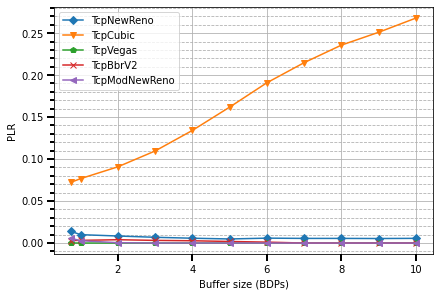

In [16]:
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(
            resulting_data[tcp_ccas[0]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[0]]['PLR']).
                         rolling(window=5, win_type=None).mean(), 'D-',
            resulting_data[tcp_ccas[1]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[1]]['PLR']).
                         rolling(window=5, win_type=None).mean(), 'v-',
            resulting_data[tcp_ccas[2]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[2]]['PLR']).
                         rolling(window=5, win_type=None).mean(), 'p-',
            resulting_data[tcp_ccas[3]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[3]]['PLR']).
                         rolling(window=5, win_type=None).mean(), 'x-',
            resulting_data[tcp_ccas[4]]['buffer'], pd.DataFrame(resulting_data[tcp_ccas[4]]['PLR']).
                         rolling(window=5, win_type=None).mean(), '<-'
        )

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.xlabel(r'Buffer size (BDPs)')
plt.ylabel(r'PLR')
#plt.xscale('log')
#x = [0.0058, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 6, 10]
#values = ['0.0', '0.05', '0.1', '0.2', '0.5', '1', '2', '4', '6', '10']
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(-0.01,0.25)
#plt.xlim(0.0005,30)
plt.grid(True)
plt.legend([
            tcp_ccas[0], tcp_ccas[1], tcp_ccas[2], tcp_ccas[3], tcp_ccas[4]
           ])
plt.show
#tikplt.save("rho_vs_L2_mx1.tex")
plt.savefig('PLR_vs_buffer.png', transparent=True)